# A neural network from first principles

The code below was adpated from the code supplied in Andrew Ng's Coursera course on machine learning. The original code was written in Matlab/Octave and in order to further my understanding and enhance my Python skills, I ported it over to Python.

To start, various libraries are imported.

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.metrics import accuracy_score
import pickle
import sys

First, we load the data. For details, please see the accompanying notebook *MNIST-loader.ipynb* for details.

In [2]:
# Load data
with open('./data/pickled/xtrain.pickle', 'rb') as f:
    xtrain = pickle.load(f)

with open('./data/pickled/ytrain.pickle', 'rb') as f:
    ytrain = pickle.load(f)

with open('./data/pickled/xtest.pickle', 'rb') as f:
    xtest = pickle.load(f)

with open('./data/pickled/ytest.pickle', 'rb') as f:
    ytest = pickle.load(f)

with open('./data/pickled/xval.pickle', 'rb') as f:
    xval = pickle.load(f)

with open('./data/pickled/yval.pickle', 'rb') as f:
    yval = pickle.load(f)

Now let's define some useful functions for the neural network to use. First is the sigmoid activation function:

In [3]:
# Sigmoid function
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

### The neural network

Below is the real meat of this notebook: the neural network funcion. The function, as defined, takes only one argument: theta. These are the weights as they are known in the moment when the function is called. At the start, these will be randomly initialized, however as the network learns these values will be changed and improved in order to minimize the cost function.

Let's walk through the basics. Firstly, the weights are provided in a "rolled" format, in other words instead of two matrices of weights, we have a single long list of weights. The first job is to "unroll" the weights into two matrices that can be efficiently used by the numpy matrix multiplication methods. To do this, we take the first *(n+1)*hidden* (i.e. 401*20 = 820) values, and reshape them into a 20X401 matrix. Next, we take the remaining 210 values (i.e. *classes*(hidden+1)*) and reshape them into a 10X21 matrix. The *n+1* and *hidden+1* take into account the bias term, which I'll discuss below.
#### Forward propagation

Next, we perform forward propagation. This is relatively simple: we multiply the input values in the layer by the weights for that layer, sum the total and add the bias term, and then and apply the sigmoid function. Recall from the reading in week one:

$$
z = w.x+b
$$

$$
a = \sigma(z) = \frac{1}{(1+e^{-z})}
$$

Since *w.x* is the dot product, it implies the sum. Basic matrix multiplication says that when multiplying two matrices that have the same internal dimension (ie number of columns in matrix one is the same as number of rows in matrix two), each element in row *i* of matrix one is multiplied by each element in column *i* of matrix two, and all of those products are summed. This value goes into the first row of the resulting matrix. Subsequently, the same is repeated for the remaining columns of the second matrix, and the first row of the output matrix is completed. This process goes on for all remaining rows in the first matrix.

In our example, the first matrix contains MNIST images in a row-wise format. The second matrix contains the weights for each connection between the input layers and the hidden layers. So following the logic from above, the first row of the input matrix (i.e. the first image in the data set) is multiplied by each of 10 sets of weights (10 columns in the weights matrix), one for each hidden layer. Because it's matrix mulitplication, all of these products are automatically summed.
#### A quick note about bias

If you look at the code below (and elsewhere in this notebook) you'll find a number of *n+1*'s and *hidden+1*'s, etc. These account for bias, the *b* term in the equation above. Every time forward propagation is run, and extra column of ones is appended onto the end of the matrix (these are not a part of the actual data). When the weights are randomly initialized, they too have an extra weight included for this bias term (i.e. the dimensions are *n*+1X*hidden*). These two values, bias in the input matrix and bias in the weights matrix, are multiplied during matrix multiplication and their product is added to the total sum for that neuron. Because the value for bias in the input matrix is always 1, the actual value of the bias is thus coded in the weights and can be learned just like a regular weight.

So to sum it all up, for each connection between a node in the input (i.e. a feature, a pixel in the image) and a node in the hidden layer, the input value is multiplied by the weight of each connection and these products for all features are added. To incorporate bias, we include an extra input value of 1 and multiply is by it's own weight. The sigmoid function is applied to this sum, and generates the value of the hidden layer for this particular data point.

#### Continuing on with forward propagation

Now we have the values of the hidden layer, we repeat this process once again with the weights for the connections between the hidden layer and the output layer. Nothing changes here, except for the sizes of the matrices. Recall that we had *n* input nodes and, say, 20 hidden layer nodes. That means we had *n+1* weights (adding 1 for the bias term), so here we will have *hidden+1* weights.

At the end of the second forward propagation, we will have a matrix with a row for each example in the data set and a column for each output class in the neural network (i.e. 10). The columns will contain the value the neural network determined for each class. If the network learned how to identify handwritten digits, the highest of these values will correspond with the correct output. At this point, however, our network has done no learning so we wouldn't expect anything better than a random guess (since the weights were randomly initialized!)

#### The cost function

Next comes the cost function. Here, we implement the cross entropy cost function with weight decay or L2 regularization. I implemented this in two lines for clarity's sake. First, the unregularized cost is determined and subsequently the regularization term is added.

Note: In the SGD version of this notebook, I removed the cost function. The *scipy.optimize* version required the cost to be calculated during training, however for SGD the cost is incoporated into the weight updates (or rather, its derivative w.r.t the weights/biases is incoporated) and so computing the cost each time is a waste of resources since it won't be used. Instead, I moved the cost calculation into the *predict* function which is 1) only called if the various monitoring parameters are set to True when training is inititated, and 2) is only calculated once per epoch, instead of on each minibatch (i.e. for 30 epochs and a mini-batch size of 10, it is calculated 30 times, instead of 15 000 times).

#### And finally, back propagation

First, we find the difference between the output values in the 10 classes and the real value. In this case, the real value for each of the 10 possible digits is a vector or length 10, with a 1 in the position representing the number in question and 0's everywhere else. For example, the number 3 is represented by [0 0 0 1 0 0 0 0 0 0]. Since the outputs are from sigmoid neurons, the values will be between 0 and 1 with the highest value indicating the number the model predicted. Sticking with the above example, we might expect our model to output something like [0.1 0.2 0.1 0.6 0.1 0.2 0.2 0.1 0.2 0.3]. Subtracting these two will give a measure of the error. The larger the value, the more incorrect that class prediction was.

To perform backpropagation, first we find the delta for the final layer (in this case, d3). This is simply the actual value (which is one-hot encoded) subtracted from the neural networks prediction for that value.

Next, we multiple the error from layer 3 by the weights that produced layer three's activation values. This is a matrix multiplication which automatically sums the totals. In this case, the matrices have the dimensions [3750X10] and [10X11], for a dot product of [3750X11]. We can simply perform an elementwise multiplication with the derivative of the sigmoid function with respect to the activations in layer 2 to get the error at layer 2.

Since we only have three layers here, we're done. There is no error on layer 1 since this was the input layer. We can't find the error on the raw values that are input to the network!

Now we would use these two delta values to update the weights and biases and then run the network again. Rinse and repeat until the cost function is appreciably minimized.

#### Wrapping this function up

As you can see, the nn function takes in a set of weights, performs forward propagation to predict the output, calculates the regularized cost using cross entropy and L2 regularization, and then performs backpropagation to determine the rate of change of the cost function with respect to the biases and weights, subsequently using the learning rate and the Lambda regularization parameter to update the weights and biases. The weights are rolled into a vector which and returned by the *nn()* function. We skipped past this at the beginning of the function, but you look back, you can see that the first thing done in the function is to unroll the weights and reshape them into matrices for efficient matrix multiplication during forward and backpropagation.

In [30]:
def nn(weights,x,y):
    
    ### Initialization
    n = len(x)
    activations = [np.array(0) for i in range(n_layers)]
    activations[0] = x
    deltas = [np.array(0) for i in range(n_layers-1)]
    bias = np.ones((n,1))
    
    ### Forward propagation
    for w,l in zip(weights,range(1,n_layers)):
        inputs = np.concatenate((bias,activations[l-1]),axis=1)
        activations[l] = sigmoid(np.dot(inputs,w.T))
    
    ### Output error
    deltas[-1] = activations[-1] - y
    
    ### Back propagation
    for l in range(2,n_layers):
        deltas[-l] = np.dot(deltas[-(l-1)],weights[-(l-1)][:,1:]) * activations[-l]*(1-activations[-l])
        
    # Update the weights / biases
    for w,l in zip(weights,range(len(layers)-1,0,-1)):
        w[:,1:] = w[:,1:] * (1-rate*Lambda/n) - np.dot(deltas[-l].T,activations[-(l+1)])*rate/n
        w[:,:1] -= np.sum(deltas[-l])*rate/n
        
    return weights

Next is the predict function. This function takes the learned weights and performs forward propagation through the netwwork using the x values supplied in the arguments. The effect of this is essentially to predict the output class of the given data using the weights that have been learned. We also calculate the cost here, because the actual cost value (and it's calculation) is only necessary if monitoring is set to True. Note: this function is only called by the accuracy tools at the end, and thus doesn't need to perform backpropagation or do any learning.

In [38]:
def predict(weights,x,y):
    
    ### Initialization
    n = len(x)
    activations = [np.array(0) for i in range(n_layers)]
    activations[0] = x
    bias = np.ones((n,1))
    
    ### Forward propagation
    for w,l in zip(weights,range(1,n_layers)):
        inputs = np.concatenate((bias,activations[l-1]),axis=1)
        activations[l] = sigmoid(np.dot(inputs,w.T))
    
    # Cost function: regularized cross entropy
    C = np.sum(np.nan_to_num(-y*np.log(activations[-1]) - (1-y)*(np.log(1-activations[-1]))))/n
    
    ws_sum_squares = 0
    for l in range(n_layers-1):
        ws_sum_squares += np.sum(weights[l][:,1:]**2)
        
    C += ((Lambda/(2*n))) * ws_sum_squares # Add regularization to the cost function
    
    return np.argmax(activations[-1],axis=1),C

We initialize theta with a set of random weights with a standard deviation of $ 1/\sqrt{n} $

In [6]:
def weight_init(L_in,L_out):
    np.random.seed(13) # This makes testing consistent.
    return np.random.normal(scale=1/np.sqrt(L_in), size=(L_out,L_in+1))

## Stochastic gradient descent

This function handles the SGD part of the learning, and will be called later on in the script when we're ready to learn the model.

First, the function calls *weight_init()* to initialize the starting weights. Empty lists are created for storing the costs and accuracies over the course of learning. Next, the function loops over the number of epochs. In each loop, the *x* and *y* matrices are shuffled and divided into mini-batches. Looping through all of the mini-batches, the *nn()* function is called to perform forward and backpropagation and update the weights accordingly. If the monitor flags are set when calling *SDG()* the predict function will produce the cost and accuracies and store them in the empty lists we created earlier.

In [31]:
def SGD(x,y,monitor_cost,monitor_train_acc,monitor_test_acc):
    
    # Make list of weights arrays
    weights = [np.array(0) for i in range(len(layers)-1)]
    for l in range(len(layers)-1):
        weights[l] = weight_init(layers[l],layers[l+1]) #[layers-1,[L_in+1,Lout]]
        
    def shuffle(x,y):
        state = np.random.get_state()
        np.random.shuffle(x)
        np.random.set_state(state)
        np.random.shuffle(y)
        return x,y        
        
    costs, test_acc, train_acc = [],[],[]
    for j in range(epochs):
        
        # Shuffle the data
        x,y = shuffle(x,y)

        # Seperate x,y mini-batches
        mini_x = [x[k:k+minibatchsize] for k in range(0,len(x),minibatchsize)]
        mini_y = [y[k:k+minibatchsize] for k in range(0,len(y),minibatchsize)]
        
        # Iterate through pairs of mini-batches, calling nn() on each pair
        for x_mini,y_mini in zip(mini_x,mini_y):
            weights = nn(weights,x_mini,y_mini)
        
        # If statements for monitoring. This ensures the predict() function isn't called unnecessarily
        if monitor_cost | monitor_train_acc:
            ypred, C = predict(weights,x,y)
        if monitor_cost:
            costs.append(C)
        if monitor_train_acc:
            train_acc.append(accuracy_score(np.argmax(y,axis=1),ypred))
        if monitor_test_acc:
            test_acc.append(accuracy_score(np.argmax(ytest,axis=1),predict(weights,xtest,ytest)[0]))
        
        # Write progress monitor
        progress = (j+1)/(epochs)*100.0
        bar = 20
        hashes = '#'*(int(round(progress/100*bar)))
        spaces = ' '*(bar-len(hashes))
        sys.stdout.write('\r[{0}] {1}%'.format(hashes + spaces, round(progress,2)))
                    
    return weights,costs,train_acc,test_acc

## Finally, we train the model

First, we specify the model parameters. Lambda is the regularization parameter, which protects against overfitting. The variable *classes* specifies the number of nodes in the output layer, *m* is the number of features in the data set (this also doubles as the number of input layers, see below), and *epochs*, *minibatchsize* and *rate* parameters are fairly self explanatory.

The *layers* variable is a list, wherin each element of the list corresponds to a layer in the network (including the input and output layers). For example, the three layer network we've been working with until now is defined by [784, 100, 10], i.e. 784 features in the input layer, 100 neurons in the single hidden layer, and 10 output neurons.

Now that all of the various elements have been coded, and the parameters have been set, we're ready to train the model using the training set, and plot the cost/accuracies.

In [135]:
# Model parameters
m = np.int(xtrain.shape[1]) # Number of features in each example
layers = [m, 100, 10]
n_layers = len(layers)

# Learning parameters
Lambda = 0.01
epochs = 40
minibatchsize = 50
rate = 0.3

# Train the model
weights, costs, train_acc, test_acc = SGD(xtrain,ytrain,True,True,True)

[####################] 100.0%

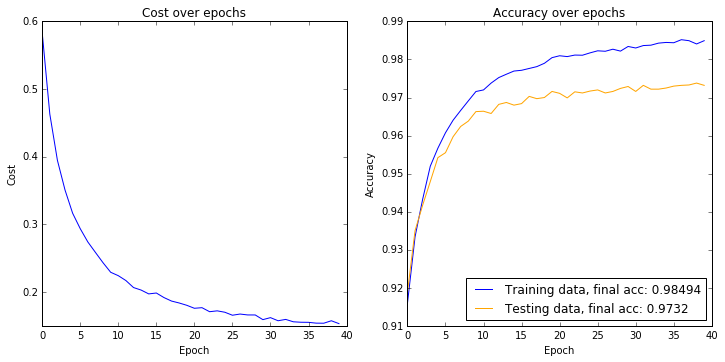

In [136]:
# Plot the results
# Note: don't bother calling unless the monitor parameters are set...
plot()

In [137]:
accuracy_score(np.argmax(yval,axis=1),predict(weights,xval,yval)[0])

0.97570000000000001

## Visualizing cost and accuracy as a function of epochs

This quick code simply plots the cost versus number of epochs and training and testing set accuracies versus number of epochs

In [40]:
def plot():# Visualize the cost and accuracy
    fig = plt.figure(figsize=(12, 12))

    ax = fig.add_subplot(221)
    ax.plot(np.arange(epochs), costs, "-")
    ax.set_xlim([0, epochs])
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Cost')
    ax.set_title('Cost over epochs')

    ax = fig.add_subplot(222)
    ax.plot(np.arange(epochs), train_acc, "-",color='blue',label="Training data, final acc: "+str(train_acc[-1]))
    ax.plot(np.arange(epochs), test_acc, "-",color='orange',label="Testing data, final acc: "+str(test_acc[-1]))
    ax.set_xlim([0, epochs])
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    plt.legend(loc='lower right')
    ax.set_title('Accuracy over epochs')

    plt.show()

## Visualizing the handwritten numbers

Here are two quick functions to visualize the actual data. First, we randomly select 100 data points and plot them. The second function grabs a single random data point, plots the image and uses the model above to predict the output.

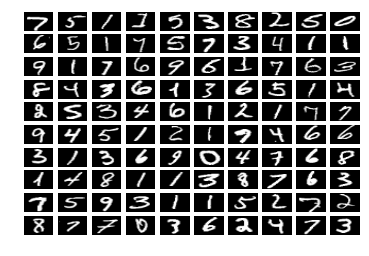

In [86]:
# Visualize the data
def drawplot(draw,x,y):
    if draw:
        n = x.shape[0]
        idx = np.random.randint(0,n,size=100) # Make an array of random integers between 0 and n
        fig, ax = plt.subplots(10, 10) # make the plots
        img_size = math.sqrt(m) # Specify the image size (in these case sqrt(m) = 28)
        for i in range(10):
            for j in range(10):
                Xi = x[idx[i*10+j],:].reshape(int(img_size), int(img_size)) # get each example and resize
                ax[i,j].set_axis_off() # Turns off the axes for all the subplots for clarity
                ax[i,j].imshow(Xi, aspect='auto',cmap='gray') # plots the current image in the correct position
        plt.show()
        
drawplot(True,xtrain,ytrain)

In [111]:
# Interactive printer function
def printer(x,y,weights):
    idx = np.random.randint(len(x),size=1)
    img_size = int(math.sqrt(m))
    xi = x[idx,:].reshape(img_size,img_size)
    yi = predict(weights,x[idx,:],y[idx,:])[0]
    plt.title('The predicted value is %i\n The true value is %i' %(yi,np.argmax(y[idx,:],axis=1)))
    plt.imshow(xi, aspect='auto',cmap='gray')
    plt.axis('off')
    plt.show()

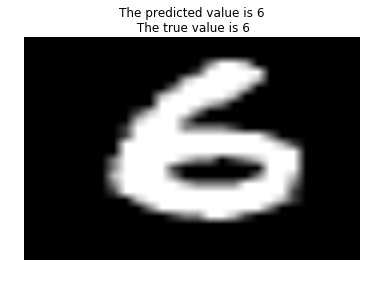

In [161]:
# Running this cell will draw a single image
# The predicted and real value for y is printed above
printer(xtest,ytest,weights)